In [291]:
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt

In [292]:
def detect_pupil(image):
    eye_cascade_path = cv2.data.haarcascades + 'haarcascade_eye.xml'
    eye_cascade = cv2.CascadeClassifier(eye_cascade_path)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    eyes = eye_cascade.detectMultiScale(gray, 1.1, 10)
    measurements = []
    for (ex, ey, ew, eh) in eyes:
        # cv2.rectangle(image, (ex, ey), (ex+ew, ey+eh), (0, 255, 0), 5)

        eye_roi = gray[ey:ey+eh, ex:ex+ew]
        eye_blur = cv2.medianBlur(eye_roi, 7)

        circles = cv2.HoughCircles(eye_blur, cv2.HOUGH_GRADIENT, dp=1, minDist=ew/8,
                                   param1=50, param2=2, minRadius=int(ew/8), maxRadius=int(ew/4))
        if circles is not None:
            circles = np.uint16(np.around(circles))
            for i in circles[0, :]:
                center_x, center_y, radius = i[0], i[1], i[2]
                if (center_x > ew/2) or (center_y > eh/2):
                    continue
                center = (ex + center_x, ey + center_y)
                cv2.circle(image, center, radius, (255, 0, 0), 2)
                cv2.circle(image, center, 3, (0, 0, 255), -1)
                measurements.append(center)
                break

    return image, measurements

In [ ]:
cap = cv2.VideoCapture(0)
start_time = time.time()
frame_count = 0

measured_positions = []
kalman_positions = []
while True:
    ret, frame = cap.read()
    if not ret:
        break

    annotated_frame, measurements = detect_pupil(frame)

    if measurements:
        for measurement in measurements:
            measured_positions.append(measurement)
            if 'kalman' not in locals():
                kalman = cv2.KalmanFilter(4, 2)
                kalman.measurementMatrix = np.array([[1, 0, 0, 0],
                                                    [0, 1, 0, 0]], np.float32)
                kalman.transitionMatrix = np.array([[1, 0, 1, 0],
                                                    [0, 1, 0, 1],
                                                    [0, 0, 1, 0],
                                                    [0, 0, 0, 1]], np.float32)
                kalman.processNoiseCov = np.array([[1, 0, 0, 0],
                                                    [0, 1, 0, 0],
                                                    [0, 0, 1, 0],
                                                    [0, 0, 0, 1]], np.float32) * 0.03

            # Update Kalman filter with new measurement
            measurement = np.array([[np.float32(measurement[0])],
                                    [np.float32(measurement[1])]])
            kalman.correct(measurement)
            prediction = kalman.predict()

            # Draw predicted position
            predicted_x = int(prediction[0])
            predicted_y = int(prediction[1])
            kalman_positions.append((predicted_x, predicted_y))

            cv2.circle(annotated_frame, (predicted_x, predicted_y), 3, (0, 255, 255), -1)


    frame_count += 1
    elapsed_time = time.time() - start_time
    fps = frame_count / elapsed_time if elapsed_time > 0 else 0
    cv2.putText(annotated_frame, f"FPS: {fps:.2f}", (10, 470),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    cv2.imshow('Pupil Detection', annotated_frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break


cap.release()
cv2.destroyAllWindows()


C:\Users\Meng\AppData\Local\Temp\ipykernel_15404\1743627312.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_x = int(prediction[0])
C:\Users\Meng\AppData\Local\Temp\ipykernel_15404\1743627312.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_y = int(prediction[1])


RMSE (pixels): [11.358632  13.9219055]


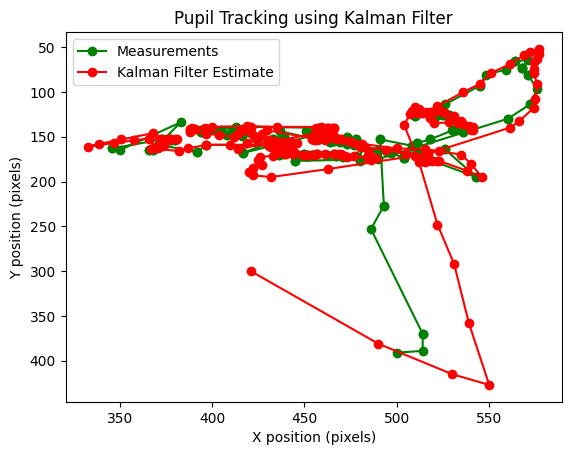

In [300]:
measured_positions = np.array(measured_positions, dtype=np.float32)
kalman_positions = np.array(kalman_positions, dtype=np.float32)

# Only evaluate on frames where a measurement exists.
if measured_positions.shape[0] > 0:
    errors = measured_positions - kalman_positions[:measured_positions.shape[0]]
    mse = np.mean(errors**2, axis=0)
    rmse = np.sqrt(mse)
    print("RMSE (pixels):", rmse)
else:
    print("No measurements to compute error.")

# Plot tracking results
plt.figure()
if measured_positions.shape[0] > 0:
    plt.plot(measured_positions[:,0], measured_positions[:,1], 'go-', label="Measurements")
plt.plot(kalman_positions[:,0], kalman_positions[:,1], 'ro-', label="Kalman Filter Estimate")
plt.xlabel("X position (pixels)")
plt.ylabel("Y position (pixels)")
plt.title("Pupil Tracking using Kalman Filter")
plt.legend()
plt.gca().invert_yaxis()
plt.show()
